In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from datasets import FrameImageDataset
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

root_dir = '/zhome/99/e/203497/MyProject/poster4/ufc10'
if not os.path.exists(root_dir):
    print('Dataset not found. Update root_dir.')
    exit()

results_dir = 'aggregation_results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
time_prefix = time.strftime('%Y-%m-%d_%H-%M-%S', time.localtime())
results_dir = os.path.join(results_dir, time_prefix)
os.makedirs(results_dir)

transform = T.Compose([T.Resize((64, 64)), T.ToTensor()])

print('Loading datasets')
train_frameimage_dataset = FrameImageDataset(root_dir=root_dir, split='train', transform=transform)
val_frameimage_dataset = FrameImageDataset(root_dir=root_dir, split='val', transform=transform)
test_frameimage_dataset = FrameImageDataset(root_dir=root_dir, split='test', transform=transform)

train_frameimage_loader = DataLoader(train_frameimage_dataset, batch_size=8, shuffle=True)
val_frameimage_loader = DataLoader(val_frameimage_dataset, batch_size=8, shuffle=False)
test_frameimage_loader = DataLoader(test_frameimage_dataset, batch_size=8, shuffle=False)

classes = train_frameimage_dataset.df['label'].unique()

# Define the model (example: using a pre-trained ResNet18)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, len(classes))  # Adjust the final layer to match the number of classes

model.load_state_dict(torch.load('/zhome/99/e/203497/MyProject/poster4/02516_poster_4/aggregation_results/2024-11-23_17-34-32/model.pth'))
model.to(device)

model.eval()
# test_acc = evaluate(test_frameimage_loader)
# print(f'Final Test Accuracy: {test_acc:.2f}%')

Using device: cuda
Loading datasets


/zhome/99/e/203497/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/zhome/99/e/203497/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_333979/3939734498.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Visualizing predictions for test video batch 120


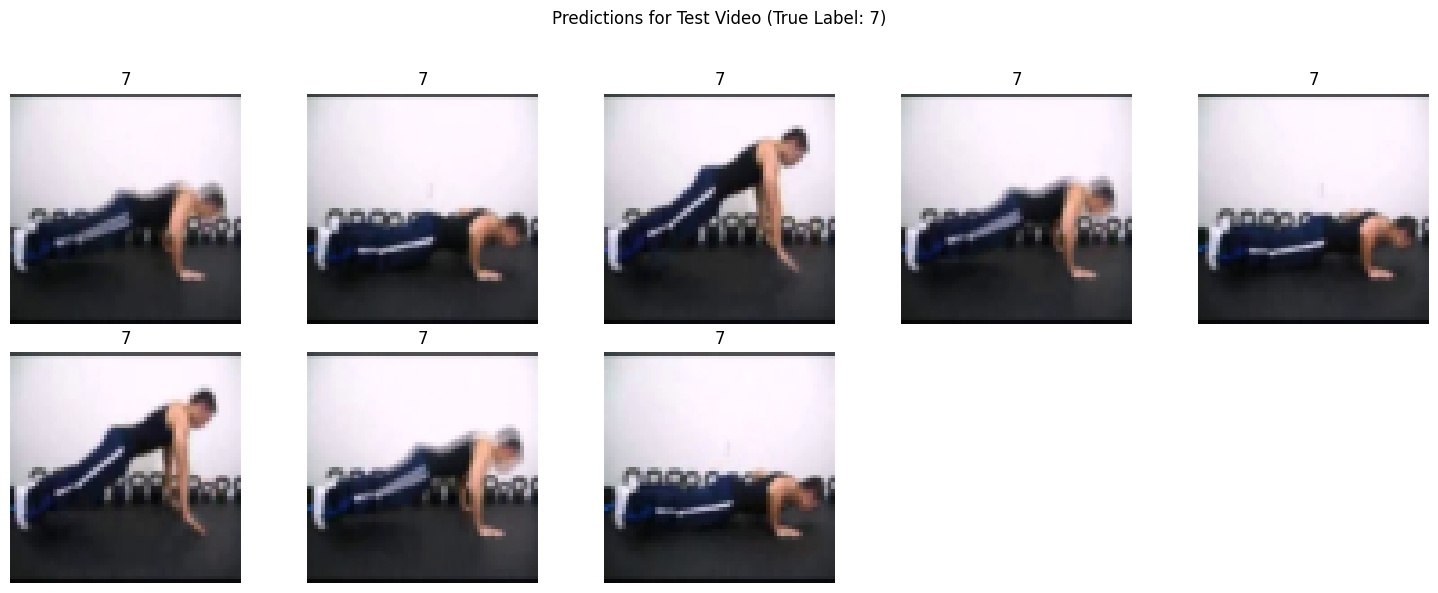

In [25]:
def visualize_predictions(test_loader, batch_index=0):
    print(f'Visualizing predictions for test video batch {batch_index}')
    test_iter = iter(test_loader)
    
    # Skip to the desired batch
    for _ in range(batch_index):
        frames, labels = next(test_iter)
    
    frames, labels = frames.to(device), labels.to(device)
    
    # Get predictions for all frames in the batch
    with torch.no_grad():
        outputs = model(frames)
        _, predicted = torch.max(outputs.data, 1)

    # Convert frames and predicted labels to CPU for visualization
    frames = frames.cpu()
    predicted_classes = [classes[p] for p in predicted]

    # Plot all 10 frames with their predicted labels
    plt.figure(figsize=(15, 6))
    for i in range(min(len(frames), 10)):  # Plot up to 10 frames
        frame = frames[i].permute(1, 2, 0).numpy()  # Rearrange dimensions for visualization
        plt.subplot(2, 5, i + 1)
        plt.imshow(frame)
        plt.title(predicted_classes[i])
        plt.axis('off')
    
    plt.suptitle(f'Predictions for Test Video (True Label: {classes[labels[0].item()]})')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(results_dir, f'test_video_predictions_batch_{batch_index}.png'))

# Example usage
visualize_predictions(test_frameimage_loader, batch_index=120)

In [ ]:
print(classes)